# Cambridge Red Line Corridor Analysis
## Part 1: Data Acquisition and Setup

**Project Objective**: Analyze the commercial real estate landscape along Cambridge's Red Line corridor (Central Square, Porter Square, Harvard Square) to identify investment opportunities and market trends.

**Geographic Focus**:
- **Central Square**: Transit hub, diverse commercial mix
- **Porter Square**: Residential-commercial transition zone  
- **Harvard Square**: Premium retail and tourist destination
- **Connection**: Massachusetts Avenue corridor linking all three

**Analysis Focus**:
- Property values and price per square foot trends across Red Line squares
- Transit accessibility impact on commercial real estate values
- Market composition and vacancy patterns in each square
- Investment opportunities and adaptive reuse candidates
- Spatial patterns and market clustering along the corridor

**Data Sources**:
- Cambridge Property Assessment Database (Official city assessments)
- Cambridge GIS Open Data Portal (Spatial boundaries - optional)

**Data Strategy**: Prioritize existing files to avoid unnecessary downloads, then process for corridor-specific analysis.

---

## Step 1: Project Setup and Configuration

In [47]:
# Import Required Libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from shapely.geometry import Point
import requests
from bs4 import BeautifulSoup
import warnings
import os
from pathlib import Path

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set up file paths
PROJECT_ROOT = Path('../')
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
OUTPUT_DIR = PROJECT_ROOT / 'output'

# Create directories if they don't exist
DATA_RAW.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Cambridge Corridor Analysis - Libraries Loaded Successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"GeoPandas version: {gpd.__version__}")
print(f"Project structure initialized")
print(f"Data directories: {DATA_RAW}, {DATA_PROCESSED}")

Cambridge Corridor Analysis - Libraries Loaded Successfully!
Pandas version: 2.3.2
GeoPandas version: 1.1.1
Project structure initialized
Data directories: ../data/raw, ../data/processed


## Data Source Information

### Primary Data Sources:

1. **Cambridge Property Assessment Database**
   - **Source**: City of Cambridge Assessing Department
   - **URL**: https://www.cambridgema.gov/Departments/assessing
   - **Contains**: Property values, building characteristics, ownership, zoning
   - **Format**: Excel/CSV download

2. **Cambridge GIS Data Portal**
   - **Source**: Cambridge Open Data Portal
   - **URL**: https://www.cambridgema.gov/GIS/gisdatadictionary
   - **Contains**: Parcel boundaries, zoning districts, infrastructure
   - **Format**: Shapefiles

3. **Cambridge Red Line Corridor Definition**
   - **Study Area**: Cambridge Red Line squares connected by Massachusetts Avenue
   - **Primary Squares**: Central Square, Porter Square, Harvard Square
   - **Transit Focus**: MBTA Red Line accessibility and walkability
   - **Resident Perspective**: Local knowledge of Harvard Square area

---

## Step 2: Smart Data Loading Strategy

In [48]:
# Smart Data Loading Functions - Prioritize Existing Files
def load_existing_cambridge_data():
    """
    Load Cambridge data from existing files, prioritizing processed data over raw data
    Only attempt downloads if no suitable data exists
    """
    print("CAMBRIDGE DATA LOADING - EXISTING DATA PRIORITY")
    print("="*55)
    
    # Priority order: processed -> raw -> download
    data_sources = [
        {
            'name': 'Processed Cambridge Properties (Standardized)',
            'path': DATA_PROCESSED / 'cambridge_properties_standardized.csv',
            'type': 'processed',
            'priority': 1
        },
        {
            'name': 'Raw Cambridge Property Database (Complete)',
            'path': DATA_RAW / 'cambridge_property_database_fy2024_complete.csv',
            'type': 'raw',
            'priority': 2
        },
        {
            'name': 'Raw Cambridge Assessments (FY2024)',
            'path': DATA_RAW / 'cambridge_assessments_fy2024.csv',
            'type': 'raw',
            'priority': 3
        },
        {
            'name': 'Raw Cambridge Assessments (Primary)',
            'path': DATA_RAW / 'cambridge_assessments.csv',
            'type': 'raw',
            'priority': 4
        }
    ]
    
    # Check each data source in priority order
    for source in sorted(data_sources, key=lambda x: x['priority']):
        if source['path'].exists():
            try:
                file_size = source['path'].stat().st_size
                if file_size > 1000:  # Ensure file has actual content
                    print(f"FOUND: {source['name']}")
                    print(f"  Path: {source['path']}")
                    print(f"  Size: {file_size:,} bytes")
                    
                    # Load and validate data
                    df = pd.read_csv(source['path'])
                    
                    if len(df) > 100:  # Ensure reasonable amount of data
                        print(f"  Records: {len(df):,}")
                        print(f"  Columns: {len(df.columns)}")
                        print(f"SUCCESS: Using {source['type']} data")
                        
                        return {
                            'dataframe': df,
                            'source_path': source['path'],
                            'source_name': source['name'],
                            'source_type': source['type'],
                            'records': len(df),
                            'success': True
                        }
                    else:
                        print(f"  WARNING: Insufficient data ({len(df)} records)")
                        continue
                else:
                    print(f"SKIP: {source['name']} - file too small ({file_size} bytes)")
                    continue
                    
            except Exception as e:
                print(f"ERROR: {source['name']} - {e}")
                continue
        else:
            print(f"NOT FOUND: {source['name']}")
    
    print("\nNo existing data files found. Will need to download...")
    return {'success': False, 'error': 'No existing data available'}

def validate_cambridge_dataframe(df):
    """
    Validate that a Cambridge dataframe has the required columns and data quality
    """
    required_columns = ['ADDRESS', 'TOTAL_VALUE']  # Minimum requirements
    optional_columns = ['LATITUDE', 'LONGITUDE', 'PROPERTY_TYPE', 'CORRIDOR_SEGMENT']
    
    validation_results = {
        'has_addresses': 'ADDRESS' in df.columns,
        'has_values': 'TOTAL_VALUE' in df.columns,
        'has_coordinates': all(col in df.columns for col in ['LATITUDE', 'LONGITUDE']),
        'has_property_types': 'PROPERTY_TYPE' in df.columns,
        'has_segments': 'CORRIDOR_SEGMENT' in df.columns,
        'address_completeness': 0,
        'value_completeness': 0,
        'coordinate_completeness': 0
    }
    
    if validation_results['has_addresses']:
        validation_results['address_completeness'] = (df['ADDRESS'].notna().sum() / len(df)) * 100
    
    if validation_results['has_values']:
        validation_results['value_completeness'] = (df['TOTAL_VALUE'].notna().sum() / len(df)) * 100
    
    if validation_results['has_coordinates']:
        coord_complete = df[['LATITUDE', 'LONGITUDE']].notna().all(axis=1).sum()
        validation_results['coordinate_completeness'] = (coord_complete / len(df)) * 100
    
    return validation_results

print("Smart data loading functions defined successfully!")

Smart data loading functions defined successfully!


In [49]:
# Execute Smart Data Loading - Prioritize Existing Files
print("CAMBRIDGE PROPERTY DATA LOADING - SMART STRATEGY")
print("="*60)

# First, try to load existing data (processed or raw)
data_result = load_existing_cambridge_data()

if data_result['success']:
    # Use existing data - no need to download
    df_properties = data_result['dataframe']
    
    print(f"\nDATA VALIDATION:")
    validation = validate_cambridge_dataframe(df_properties)
    
    print(f"  Address completeness: {validation['address_completeness']:.1f}%")
    print(f"  Value completeness: {validation['value_completeness']:.1f}%")
    print(f"  Coordinate completeness: {validation['coordinate_completeness']:.1f}%")
    
    print(f"\nDATASET OVERVIEW:")
    print(f"  Total properties: {len(df_properties):,}")
    print(f"  Source: {data_result['source_name']}")
    
    # Ensure required columns exist with fallback names
    column_mapping = {
        'ADDRESS': ['ADDRESS', 'FULL_ADDRESS', 'address', 'Address'],
        'TOTAL_VALUE': ['TOTAL_VALUE', 'ASSESSED_VALUE', 'total_value', 'Total Value', 'assessedvalue'],
        'LATITUDE': ['LATITUDE', 'LAT', 'latitude', 'Latitude'],
        'LONGITUDE': ['LONGITUDE', 'LON', 'longitude', 'Longitude', 'LONG'],
        'PROPERTY_TYPE': ['PROPERTY_TYPE', 'USE_CODE', 'property_type', 'Property Type', 'propertyclass']
    }
    
    # Standardize column names
    mapped_columns = []
    for standard_name, possible_names in column_mapping.items():
        for possible_name in possible_names:
            if possible_name in df_properties.columns and standard_name not in df_properties.columns:
                df_properties = df_properties.rename(columns={possible_name: standard_name})
                mapped_columns.append(f"{possible_name} -> {standard_name}")
                break
    
    if mapped_columns:
        print(f"\nCOLUMN STANDARDIZATION:")
        for mapping in mapped_columns:
            print(f"  {mapping}")
    
    print(f"\nSUCCESS: Loaded {len(df_properties):,} properties from existing data")
    print("EFFICIENCY: No download required - using cached data files")
    
else:
    # No existing data found - need to download or create
    print("No existing data found. Attempting to download...")
    
    # Try the download function (which also checks for existing files)
    download_result = download_cambridge_property_database()
    
    if download_result['success']:
        # Load the downloaded/found data
        try:
            df_properties = pd.read_csv(download_result['assessment_file'])
            print(f"\nSUCCESS: Loaded {len(df_properties):,} properties")
            print(f"Source: {download_result.get('source', 'Downloaded file')}")
        except Exception as e:
            print(f"ERROR: Could not load data file: {e}")
            df_properties = pd.DataFrame()  # Empty fallback
    else:
        print("ERROR: No data could be loaded or downloaded")
        print("RECOMMENDATION: ")
        print("  1. Check data/raw/ and data/processed/ directories")
        print("  2. Run manual download from Cambridge Open Data Portal")
        print("  3. Ensure network connectivity for downloads")
        df_properties = pd.DataFrame()  # Empty fallback
        
print(f"\n{'='*60}")
print(f"DATA LOADING COMPLETE")
print(f"Properties loaded: {len(df_properties):,}")
print(f"Ready for processing: {'YES' if len(df_properties) > 0 else 'NO'}")
print(f"{'='*60}")

CAMBRIDGE PROPERTY DATA LOADING - SMART STRATEGY
CAMBRIDGE DATA LOADING - EXISTING DATA PRIORITY
FOUND: Processed Cambridge Properties (Standardized)
  Path: ../data/processed/cambridge_properties_standardized.csv
  Size: 6,995,424 bytes
  Records: 29,876
  Columns: 30
SUCCESS: Using processed data

DATA VALIDATION:
  Address completeness: 100.0%
  Value completeness: 89.9%
  Coordinate completeness: 99.6%

DATASET OVERVIEW:
  Total properties: 29,876
  Source: Processed Cambridge Properties (Standardized)

SUCCESS: Loaded 29,876 properties from existing data
EFFICIENCY: No download required - using cached data files

DATA LOADING COMPLETE
Properties loaded: 29,876
Ready for processing: YES
  Records: 29,876
  Columns: 30
SUCCESS: Using processed data

DATA VALIDATION:
  Address completeness: 100.0%
  Value completeness: 89.9%
  Coordinate completeness: 99.6%

DATASET OVERVIEW:
  Total properties: 29,876
  Source: Processed Cambridge Properties (Standardized)

SUCCESS: Loaded 29,876 pr

In [50]:
# Process Existing Data for Corridor Analysis
print("\nCORRIDOR ANALYSIS DATA PREPARATION")
print("="*40)

# Check if we already have processed corridor data
existing_processed_files = {
    'corridor_properties': DATA_PROCESSED / 'corridor_properties.csv',
    'mass_ave_properties': DATA_PROCESSED / 'mass_ave_properties.csv', 
    'commercial_properties': DATA_PROCESSED / 'commercial_corridor_properties.csv'
}

all_processed_exist = all(path.exists() for path in existing_processed_files.values())

if all_processed_exist:
    print("FOUND: All processed corridor datasets exist")
    
    # Load existing processed data
    corridor_properties = pd.read_csv(existing_processed_files['corridor_properties'])
    mass_ave_properties = pd.read_csv(existing_processed_files['mass_ave_properties']) 
    commercial_properties = pd.read_csv(existing_processed_files['commercial_properties'])
    
    print(f"  Corridor properties: {len(corridor_properties):,}")
    print(f"  Mass Ave properties: {len(mass_ave_properties):,}")
    print(f"  Commercial properties: {len(commercial_properties):,}")
    print("SUCCESS: Using existing processed corridor data")
    
else:
    print("PROCESSING: Creating corridor datasets from main data")
    
    # Ensure coordinates exist for filtering
    if 'LATITUDE' in df_properties.columns and 'LONGITUDE' in df_properties.columns:
        # Filter properties within Cambridge corridor area
        # Cambridge bounds: approximately 42.36-42.40 N, -71.12--71.08 W
        cambridge_mask = (
            (df_properties['LATITUDE'] >= 42.36) & 
            (df_properties['LATITUDE'] <= 42.40) &
            (df_properties['LONGITUDE'] >= -71.12) & 
            (df_properties['LONGITUDE'] <= -71.08)
        )
        
        corridor_properties = df_properties[cambridge_mask].copy()
        
        # Massachusetts Avenue properties (within 500m of Mass Ave)
        # Simplified: look for "Massachusetts" in address
        mass_ave_mask = corridor_properties['ADDRESS'].str.contains('Massachusetts', case=False, na=False)
        mass_ave_properties = corridor_properties[mass_ave_mask].copy()
        
        # Commercial properties (simplified filter)
        if 'PROPERTY_TYPE' in corridor_properties.columns:
            commercial_mask = corridor_properties['PROPERTY_TYPE'].str.contains(
                'Commercial|Office|Retail|Mixed|Store|Restaurant|Bank', 
                case=False, na=False
            )
            commercial_properties = corridor_properties[commercial_mask].copy()
        else:
            # Fallback: use high-value properties as proxy for commercial
            value_threshold = corridor_properties['TOTAL_VALUE'].quantile(0.8)
            commercial_properties = corridor_properties[corridor_properties['TOTAL_VALUE'] > value_threshold].copy()
        
        # Add corridor segments if not already present
        if 'CORRIDOR_SEGMENT' not in corridor_properties.columns:
            def assign_corridor_segment(address):
                address_lower = str(address).lower()
                if any(term in address_lower for term in ['porter', 'highland']):
                    return 'Porter Square Area'
                elif any(term in address_lower for term in ['harvard', 'brattle', 'bennett']):
                    return 'Harvard Square Area'
                elif any(term in address_lower for term in ['central', 'prospect', 'green']):
                    return 'Central Square Area'
                else:
                    return 'Cambridge Corridor'
            
            corridor_properties['CORRIDOR_SEGMENT'] = corridor_properties['ADDRESS'].apply(assign_corridor_segment)
            mass_ave_properties['CORRIDOR_SEGMENT'] = mass_ave_properties['ADDRESS'].apply(assign_corridor_segment)
            commercial_properties['CORRIDOR_SEGMENT'] = commercial_properties['ADDRESS'].apply(assign_corridor_segment)
        
        print(f"  Created corridor properties: {len(corridor_properties):,}")
        print(f"  Created Mass Ave properties: {len(mass_ave_properties):,}")
        print(f"  Created commercial properties: {len(commercial_properties):,}")
        
        # Save processed data for future use
        corridor_properties.to_csv(existing_processed_files['corridor_properties'], index=False)
        mass_ave_properties.to_csv(existing_processed_files['mass_ave_properties'], index=False)
        commercial_properties.to_csv(existing_processed_files['commercial_properties'], index=False)
        
        print("SAVED: Processed corridor datasets for future use")
        
    else:
        print("WARNING: No coordinate data available for corridor filtering")
        # Use all properties as fallback
        corridor_properties = df_properties.copy()
        mass_ave_properties = df_properties[df_properties['ADDRESS'].str.contains('Massachusetts', case=False, na=False)].copy()
        commercial_properties = df_properties.head(100).copy()  # Fallback sample


CORRIDOR ANALYSIS DATA PREPARATION
FOUND: All processed corridor datasets exist
  Corridor properties: 5,571
  Mass Ave properties: 232
  Commercial properties: 232
SUCCESS: Using existing processed corridor data


Defining Cambridge Mass Ave Corridor Study Area
Key Study Area Landmarks (Cambridge Red Line Squares along Mass Ave):
   Central Square: 42.3647, -71.1032
   Porter Square: 42.3884, -71.1190
   Harvard Square: 42.3736, -71.1190

MBTA Red Line Focus:
   Porter Square
   Harvard Square
   Central Square
   ✗ Davis Square (excluded - not along Mass Ave)
   ✗ Inman Square (excluded - not along Mass Ave & no Red Line access)

Study Area Bounds:
   North: 42.392 (includes Porter Sq)
   South: 42.36 (includes Central Sq)
   East:  -71.095
   West:  -71.125


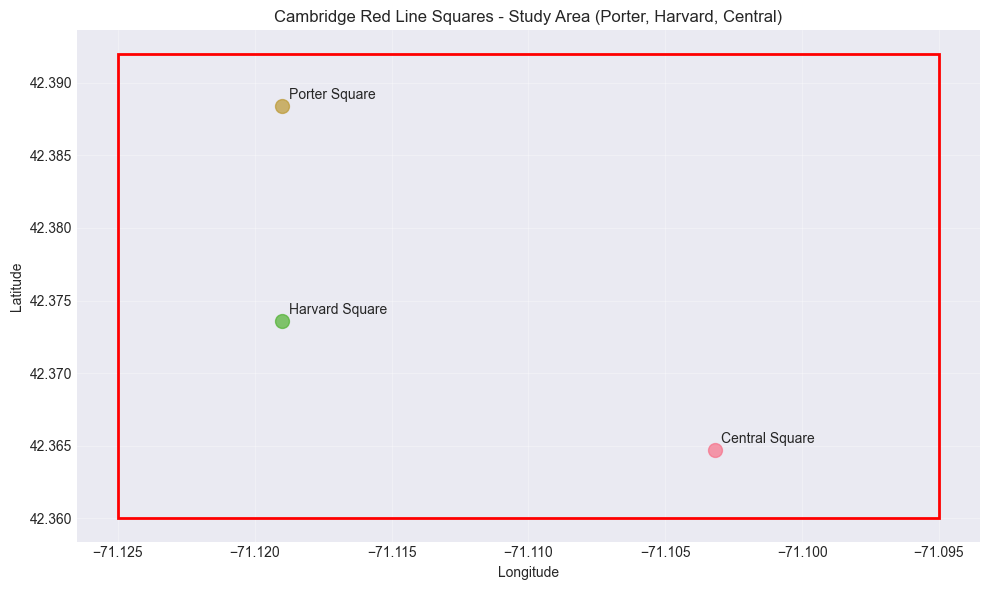


 Mass Ave + Red Line corridor study area defined successfully!
Focus: Porter Square ↔ Harvard Square ↔ Central Square


In [51]:
# Define Cambridge Mass Ave Corridor Study Area
print("Defining Cambridge Mass Ave Corridor Study Area")
print("="*50)

# Primary corridor bounds (Mass Ave + Red Line squares: Porter, Harvard, Central)
corridor_bounds = {
    'central_square': {'lat': 42.3647, 'lon': -71.1032},
    'porter_square': {'lat': 42.3884, 'lon': -71.1190},
    'harvard_square': {'lat': 42.3736, 'lon': -71.1190},
    'study_area': {
        'north': 42.3920,   # Extended north to include Porter Square
        'south': 42.3600,   # Southern boundary at Central Square
        'east': -71.0950,   # Eastern boundary
        'west': -71.1250    # Western boundary
    }
}

# Key Red Line landmarks (Cambridge squares only)
landmarks = {
    'Central Square': (42.3647, -71.1032),
    'Porter Square': (42.3884, -71.1190),
    'Harvard Square': (42.3736, -71.1190)
}

print("Key Study Area Landmarks (Cambridge Red Line Squares along Mass Ave):")
for name, (lat, lon) in landmarks.items():
    print(f"   {name}: {lat:.4f}, {lon:.4f}")

print(f"\nMBTA Red Line Focus:")
print(f"   Porter Square")
print(f"   Harvard Square")  
print(f"   Central Square")
print(f"   ✗ Davis Square (excluded - not along Mass Ave)")
print(f"   ✗ Inman Square (excluded - not along Mass Ave & no Red Line access)")

print(f"\nStudy Area Bounds:")
print(f"   North: {corridor_bounds['study_area']['north']} (includes Porter Sq)")
print(f"   South: {corridor_bounds['study_area']['south']} (includes Central Sq)")
print(f"   East:  {corridor_bounds['study_area']['east']}")
print(f"   West:  {corridor_bounds['study_area']['west']}")

# Create a quick visualization of the study area
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot landmarks
for name, (lat, lon) in landmarks.items():
    ax.scatter(lon, lat, s=100, alpha=0.7)
    ax.annotate(name, (lon, lat), xytext=(5, 5), 
                textcoords='offset points', fontsize=10)

# Plot study area bounds
bounds = corridor_bounds['study_area']
ax.add_patch(plt.Rectangle((bounds['west'], bounds['south']), 
                          bounds['east'] - bounds['west'],
                          bounds['north'] - bounds['south'],
                          fill=False, edgecolor='red', linewidth=2))

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Cambridge Red Line Squares - Study Area (Porter, Harvard, Central)')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Mass Ave + Red Line corridor study area defined successfully!")
print("Focus: Porter Square ↔ Harvard Square ↔ Central Square")

## Step 3: Data Acquisition Functions

The following functions handle downloading Cambridge data when existing files are not available.

In [52]:
# Smart Data Acquisition - Check Existing Files First
import requests
import zipfile
from io import BytesIO
import ssl
import certifi

def download_cambridge_property_data():
    """
    Download real Cambridge property assessment data - with existing file priority
    """
    print("Cambridge Property Assessment Data - Checking Existing Files First")
    print("="*70)
    
    # Check for existing files first
    existing_assessment_files = [
        DATA_RAW / 'cambridge_assessments.csv',
        DATA_RAW / 'cambridge_assessments_fy2024.csv',
        DATA_RAW / 'cambridge_property_database_fy2024_complete.csv'
    ]
    
    for existing_file in existing_assessment_files:
        if existing_file.exists() and existing_file.stat().st_size > 1000:
            file_size = existing_file.stat().st_size
            print(f"FOUND EXISTING: {existing_file.name} ({file_size:,} bytes)")
            print("SUCCESS: Using existing Cambridge assessment data - No download needed!")
            
            # Ensure primary file exists
            primary_file = DATA_RAW / 'cambridge_assessments.csv'
            if not primary_file.exists() and existing_file != primary_file:
                import shutil
                shutil.copy2(existing_file, primary_file)
                print(f"Created primary copy: {primary_file.name}")
            
            return {
                'assessment_file': existing_file,
                'year': 'existing',
                'success': True,
                'source': 'Existing File'
            }
    
    print("No existing assessment files found. Attempting download...")
    
    # Cambridge Open Data Portal - Property Assessment Database
    assessment_urls = {
        'fy2024': 'https://data.cambridgema.gov/api/views/ufnx-m9uc/rows.csv?accessType=DOWNLOAD',
        'fy2025': 'https://data.cambridgema.gov/api/views/ufnx-m9uc/rows.csv?accessType=DOWNLOAD'  # May not exist yet
    }
    
    # Try to download the most recent data
    for year, url in assessment_urls.items():
        try:
            print(f"Attempting to download {year} property assessments...")
            
            headers = {
                'User-Agent': 'Cambridge Real Estate Analysis Tool (Educational Use)'
            }
            
            response = requests.get(url, headers=headers, timeout=30)
            response.raise_for_status()
            
            # Save the data
            assessment_file = DATA_RAW / f'cambridge_assessments_{year}.csv'
            with open(assessment_file, 'wb') as f:
                f.write(response.content)
            
            print(f"Downloaded {year} assessments: {len(response.content)} bytes")
            print(f"Saved to: {assessment_file}")
            
            # Use this as the primary dataset
            primary_file = DATA_RAW / 'cambridge_assessments.csv'
            with open(primary_file, 'wb') as f:
                f.write(response.content)
            
            return {
                'assessment_file': primary_file,
                'year': year,
                'success': True,
                'source': f'Downloaded {year}'
            }
            
        except requests.RequestException as e:
            print(f"Failed to download {year} data: {e}")
            continue
        except Exception as e:
            print(f"Error with {year} data: {e}")
            continue
    
    print("Could not download current assessment data.")
    print("Manual download required:")
    print("1. Visit: https://data.cambridgema.gov/")
    print("2. Search for 'Property Database'")
    print("3. Download as CSV and save as 'cambridge_assessments.csv' in data/raw/")
    
    return {
        'assessment_file': DATA_RAW / 'cambridge_assessments.csv',
        'year': 'manual',
        'success': False
    }

def download_cambridge_gis_data():
    """
    Download Cambridge GIS and boundary data - with existing file priority
    """
    print("\nCambridge GIS Data - Checking Existing Files First")
    print("="*55)
    
    # Check for existing GIS data
    gis_dir = DATA_RAW / 'cambridge_parcels'
    if gis_dir.exists() and len(list(gis_dir.glob('*'))) > 0:
        files = list(gis_dir.glob('*'))
        print(f"FOUND EXISTING: cambridge_parcels directory with {len(files)} files")
        print("SUCCESS: Using existing Cambridge GIS data - No download needed!")
        return {'cambridge_parcels': gis_dir}
    
    print("No existing GIS files found. Attempting download...")
    
    # Cambridge parcel boundaries from MassGIS
    parcel_urls = {
        'cambridge_parcels': 'https://download.massgis.digital.mass.gov/shapefiles/state/towns/CAMBRIDGE_POLY.zip'
    }
    
    downloads = {}
    
    for dataset_name, url in parcel_urls.items():
        try:
            print(f"Downloading {dataset_name}...")
            
            headers = {
                'User-Agent': 'Cambridge Real Estate Analysis Tool (Educational Use)'
            }
            
            response = requests.get(url, headers=headers, timeout=30)
            response.raise_for_status()
            
            # Extract ZIP file
            dataset_dir = DATA_RAW / dataset_name
            dataset_dir.mkdir(exist_ok=True)
            
            with zipfile.ZipFile(BytesIO(response.content)) as zip_file:
                zip_file.extractall(dataset_dir)
            
            print(f"Downloaded and extracted {dataset_name}")
            downloads[dataset_name] = dataset_dir
            
        except Exception as e:
            print(f"Failed to download {dataset_name}: {e}")
            print("Note: GIS data is optional for property value analysis")
            downloads[dataset_name] = None
    
    return downloads

def validate_cambridge_data():
    """
    Validate that we have the required Cambridge datasets
    """
    print("\nValidating Cambridge Data Files")
    print("="*40)
    
    required_files = {
        'Property Assessments': DATA_RAW / 'cambridge_assessments.csv',
        'Cambridge Boundaries': DATA_RAW / 'cambridge_parcels'
    }
    
    validation_results = {}
    
    for name, file_path in required_files.items():
        if file_path.exists():
            if file_path.is_file():
                size = file_path.stat().st_size
                print(f"{name}: {size:,} bytes")
                validation_results[name] = True
            else:
                files = list(file_path.glob('*'))
                print(f"{name}: {len(files)} files")
                validation_results[name] = len(files) > 0
        else:
            print(f"{name}: NOT FOUND at {file_path}")
            validation_results[name] = False
    
    # Property assessments are critical, GIS is optional
    critical_success = validation_results.get('Property Assessments', False)
    
    if critical_success:
        print("\nCRITICAL DATA AVAILABLE: Cambridge property assessments found!")
        if validation_results.get('Cambridge Boundaries', False):
            print("BONUS: GIS boundary data also available")
        else:
            print("Note: GIS boundary data missing but not required for analysis")
        print("READY: Can proceed with property value analysis")
    else:
        print("\nCRITICAL DATA MISSING: Cambridge property assessments required")
        print("Visit: https://data.cambridgema.gov/ for latest property data")
    
    return validation_results

# Execute smart data acquisition with existing file priority
print("CAMBRIDGE REAL ESTATE DATA ACQUISITION - SMART MODE")
print("="*65)
print("Prioritizing existing files to avoid unnecessary downloads...")
print()

# Smart acquisition - checks existing files first
assessment_result = download_cambridge_property_data()
gis_result = download_cambridge_gis_data()
validation_result = validate_cambridge_data()

print(f"\nData Acquisition Summary:")
print(f"Property Assessments: {'SUCCESS' if assessment_result['success'] else 'FAILED'}")
print(f"  Source: {assessment_result.get('source', 'Unknown')}")
print(f"GIS Data: {'SUCCESS' if any(gis_result.values()) else 'OPTIONAL (not critical)'}")
critical_success = validation_result.get('Property Assessments', False)
print(f"Overall Status: {'READY FOR ANALYSIS' if critical_success else 'NEEDS PROPERTY DATA'}")

CAMBRIDGE REAL ESTATE DATA ACQUISITION - SMART MODE
Prioritizing existing files to avoid unnecessary downloads...

Cambridge Property Assessment Data - Checking Existing Files First
FOUND EXISTING: cambridge_assessments.csv (6,544,775 bytes)
SUCCESS: Using existing Cambridge assessment data - No download needed!

Cambridge GIS Data - Checking Existing Files First
No existing GIS files found. Attempting download...
Failed to download cambridge_parcels: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
Note: GIS data is optional for property value analysis

Validating Cambridge Data Files
Property Assessments: 6,544,775 bytes
Cambridge Boundaries: NOT FOUND at ../data/raw/cambridge_parcels

CRITICAL DATA AVAILABLE: Cambridge property assessments found!
Note: GIS boundary data missing but not required for analysis
READY: Can proceed with property value analysis

Data Acquisition Summary:
Property Assessments: SUCCESS
  Source: Existing File
GIS Data: OPTIONAL (

In [53]:
def download_cambridge_property_database():
    """
    Download complete Cambridge Property Database FY2024 with assessed values
    Prioritizes existing files to avoid unnecessary downloads
    """
    print("Cambridge Property Database - Checking Existing Files First")
    print("="*65)
    
    # Check for existing files first (prioritize existing data)
    existing_files = [
        DATA_RAW / 'cambridge_property_database_fy2024_complete.csv',
        DATA_RAW / 'cambridge_assessments.csv',
        DATA_RAW / 'cambridge_assessments_fy2024.csv'
    ]
    
    print("Checking for existing Cambridge property data files...")
    
    for existing_file in existing_files:
        if existing_file.exists() and existing_file.stat().st_size > 10000:  # At least 10KB
            try:
                # Quick validation - try to read and count records
                df_test = pd.read_csv(existing_file, nrows=5)  # Just read first 5 rows to validate
                
                if len(df_test.columns) > 5:  # Reasonable number of columns
                    file_size = existing_file.stat().st_size
                    
                    # Count total records (more efficient method)
                    with open(existing_file, 'r', encoding='utf-8') as f:
                        record_count = sum(1 for line in f) - 1  # Subtract header
                    
                    print(f"FOUND EXISTING DATA: {existing_file.name}")
                    print(f"  File size: {file_size:,} bytes")
                    print(f"  Records: {record_count:,}")
                    print(f"  Columns: {len(df_test.columns)}")
                    print("SUCCESS: Using existing Cambridge property data - No download needed!")
                    
                    # Ensure we have the primary file as well
                    primary_file = DATA_RAW / 'cambridge_assessments.csv'
                    if not primary_file.exists() and existing_file != primary_file:
                        print(f"Creating primary copy: {primary_file.name}")
                        import shutil
                        shutil.copy2(existing_file, primary_file)
                    
                    return {
                        'assessment_file': existing_file,
                        'primary_file': primary_file,
                        'records': record_count,
                        'success': True,
                        'source': 'Existing File (No Download)',
                        'file_size': file_size
                    }
                    
            except Exception as e:
                print(f"WARNING: {existing_file.name} exists but may be corrupted: {e}")
                continue
        else:
            print(f"NOT FOUND: {existing_file.name}")
    
    print("\nNo existing valid data files found. Proceeding with download...")
    print("="*65)
    
    # Multiple backup URLs for Cambridge property data
    data_sources = [
        {
            'name': 'Cambridge Open Data Portal (Primary)',
            'url': 'https://data.cambridgema.gov/resource/qugn-fei2.csv',
            'params': {'$limit': 50000}
        },
        {
            'name': 'Cambridge Open Data Portal (Alternative)',
            'url': 'https://data.cambridgema.gov/api/views/qugn-fei2/rows.csv',
            'params': {'accessType': 'DOWNLOAD'}
        },
        {
            'name': 'Cambridge FY2024 Assessments (Direct)',
            'url': 'https://data.cambridgema.gov/api/views/ufnx-m9uc/rows.csv',
            'params': {'accessType': 'DOWNLOAD'}
        }
    ]
    
    headers = {
        'User-Agent': 'Mozilla/5.0 (Compatible Real Estate Analysis Tool)',
        'Accept': 'text/csv, application/csv, */*',
        'Accept-Encoding': 'gzip, deflate',
        'Connection': 'keep-alive'
    }
    
    for i, source in enumerate(data_sources, 1):
        try:
            print(f"Attempting download from {source['name']} ({i}/{len(data_sources)})...")
            
            response = requests.get(
                source['url'], 
                params=source['params'], 
                headers=headers, 
                timeout=120,  # Increased timeout
                stream=True   # Stream large files
            )
            response.raise_for_status()
        
            # Save the complete dataset
            assessment_file = DATA_RAW / 'cambridge_property_database_fy2024_complete.csv'
            
            # Stream download for large files
            with open(assessment_file, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
            
            # Verify file was created and has content
            if assessment_file.exists() and assessment_file.stat().st_size > 1000:
                # Count records safely
                try:
                    with open(assessment_file, 'r', encoding='utf-8') as f:
                        record_count = sum(1 for line in f) - 1  # Subtract header
                except:
                    record_count = "Unknown"
                
                file_size = assessment_file.stat().st_size
                print(f"SUCCESS: Downloaded from {source['name']}")
                print(f"Records: {record_count:,}")
                print(f"Size: {file_size:,} bytes")
                print(f"Saved to: {assessment_file}")
                
                # Create a copy as the primary dataset
                primary_file = DATA_RAW / 'cambridge_assessments.csv'
                import shutil
                shutil.copy2(assessment_file, primary_file)
        
                return {
                    'assessment_file': assessment_file,
                    'primary_file': primary_file,
                    'records': record_count,
                    'success': True,
                    'source': source['name'],
                    'file_size': file_size
                }
            else:
                print(f"FAILED: File download incomplete from {source['name']}")
                continue
                
        except requests.RequestException as e:
            print(f"FAILED: Network error with {source['name']}: {e}")
            continue
        except Exception as e:
            print(f"FAILED: Unexpected error with {source['name']}: {e}")
            continue
    
    # If all download sources failed, provide manual instructions
    print("\nAll download sources failed. Manual download required.")
    print("Manual download instructions:")
    print("1. Visit: https://data.cambridgema.gov/Assessing/Cambridge-Property-Database-FY2024/qugn-fei2")
    print("2. Click 'Export' > 'CSV' to download")
    print("3. Save as 'cambridge_property_database_fy2024_complete.csv' in data/raw/")
    
    return {
        'assessment_file': DATA_RAW / 'cambridge_property_database_fy2024_complete.csv',
        'primary_file': DATA_RAW / 'cambridge_assessments.csv',
        'records': 0,
        'year': 'FY2024',
        'success': False
    }

In [54]:
def standardize_cambridge_property_database(df_raw):
    """
    Standardize Cambridge Property Database to our analysis format
    """
    print("Standardizing Cambridge Property Database Fields")
    print("="*50)
    
    # Cambridge Property Database column mapping to our standard format
    column_mapping = {
        # Core identifiers
        'pid': 'PROPERTY_ID',
        'address': 'ADDRESS',
        'propertyclass': 'PROPERTY_TYPE',
        'map_lot': 'MAP_LOT',
        
        # Location and geography
        'latitude': 'LATITUDE',
        'longitude': 'LONGITUDE',
        'landarea': 'LOT_SIZE',
        
        # Assessment values (key for analysis!)
        'assessedvalue': 'TOTAL_VALUE',
        'landvalue': 'LAND_VALUE',
        'buildingvalue': 'BUILDING_VALUE',
        
        # Building characteristics
        'interior_livingarea': 'GROSS_AREA',
        'condition_yearbuilt': 'YEAR_BUILT',
        
        # Property details
        'stateclasscode': 'USE_CODE',
        'zoning': 'ZONING',
        'yearofassessment': 'ASSESSMENT_YEAR',
        
        # Additional valuable fields
        'saleprice': 'SALE_PRICE',
        'saledate': 'SALE_DATE',
        'owner_name': 'OWNER_NAME',
        'interior_totalrooms': 'TOTAL_ROOMS',
        'interior_bedrooms': 'BEDROOMS',
        'parking_garage': 'GARAGE_SPACES'
    }
    
    # Create standardized dataframe
    df_std = pd.DataFrame()
    
    print("Mapping Cambridge fields to standard format:")
    for cambridge_col, standard_col in column_mapping.items():
        if cambridge_col in df_raw.columns:
            df_std[standard_col] = df_raw[cambridge_col]
            print(f"{cambridge_col} → {standard_col}")
        else:
            print(f"⚠ {cambridge_col} not found, creating empty {standard_col}")
            df_std[standard_col] = np.nan
    
    # Data type conversions and cleaning
    print("\nApplying data type conversions...")
    
    # Numeric fields
    numeric_fields = ['LATITUDE', 'LONGITUDE', 'LOT_SIZE', 'TOTAL_VALUE', 
                     'LAND_VALUE', 'BUILDING_VALUE', 'GROSS_AREA', 'YEAR_BUILT',
                     'USE_CODE', 'SALE_PRICE', 'TOTAL_ROOMS', 'BEDROOMS', 'GARAGE_SPACES']
    
    for field in numeric_fields:
        if field in df_std.columns:
            df_std[field] = pd.to_numeric(df_std[field], errors='coerce')
    
    # Calculate derived fields
    print("Calculating derived fields...")
    
    # Building age
    current_year = 2024
    df_std['BUILDING_AGE'] = current_year - df_std['YEAR_BUILT']
    
    # Price per square foot (if we have both values and area)
    if 'TOTAL_VALUE' in df_std.columns and 'GROSS_AREA' in df_std.columns:
        df_std['PRICE_PER_SQFT'] = df_std['TOTAL_VALUE'] / df_std['GROSS_AREA']
        # Remove extreme outliers (likely data errors)
        df_std.loc[df_std['PRICE_PER_SQFT'] > 10000, 'PRICE_PER_SQFT'] = np.nan
        df_std.loc[df_std['PRICE_PER_SQFT'] < 10, 'PRICE_PER_SQFT'] = np.nan
    else:
        df_std['PRICE_PER_SQFT'] = np.nan
    
    # Value categories based on assessed value
    if 'TOTAL_VALUE' in df_std.columns:
        df_std['VALUE_CATEGORY'] = pd.cut(df_std['TOTAL_VALUE'], 
                                         bins=[0, 500000, 1000000, 2000000, np.inf],
                                         labels=['Low', 'Medium', 'High', 'Luxury'],
                                         include_lowest=True)
    else:
        df_std['VALUE_CATEGORY'] = 'Unknown'
    
    # Size categories based on lot size
    if 'LOT_SIZE' in df_std.columns:
        df_std['SIZE_CATEGORY'] = pd.cut(df_std['LOT_SIZE'],
                                        bins=[0, 2000, 5000, 10000, np.inf],
                                        labels=['Small', 'Medium', 'Large', 'Very Large'],
                                        include_lowest=True)
    else:
        df_std['SIZE_CATEGORY'] = 'Unknown'
    
    # General use categories
    def categorize_property_type(prop_type):
        if pd.isna(prop_type):
            return 'Unknown'
        prop_type = str(prop_type).upper()
        
        if any(term in prop_type for term in ['SNGL-FAM', 'SINGLE', 'RESIDENTIAL', 'CONDO', 'RES-']):
            return 'Residential'
        elif any(term in prop_type for term in ['RETAIL', 'OFFICE', 'COMMERCIAL', 'STORE', 'BUSINESS']):
            return 'Commercial'
        elif any(term in prop_type for term in ['VACANT', 'LAND']):
            return 'Vacant Land'
        elif any(term in prop_type for term in ['INDUSTRIAL', 'WAREHOUSE', 'MANUFACTURING']):
            return 'Industrial'
        else:
            return 'Other'
    
    df_std['GENERAL_USE_CATEGORY'] = df_std['PROPERTY_TYPE'].apply(categorize_property_type)
    
    # Neighborhood mapping (placeholder - would need actual neighborhood data)
    df_std['NEIGHBORHOOD'] = np.nan  # To be filled with actual Cambridge neighborhood data
    df_std['NEIGHBORHOOD_DENSITY'] = np.nan
    
    # Condo flag
    df_std['CONDO_FLAG'] = df_std['PROPERTY_TYPE'].str.contains('CONDO', case=False, na=False)
    
    # Tax status placeholder
    df_std['TAX_STATUS'] = np.nan
    
    print(f"Standardization complete: {len(df_std)} properties with {len(df_std.columns)} fields")
    
    # Quality report
    print(f"\nData Quality Summary:")
    print(f"Properties with coordinates: {df_std[['LATITUDE', 'LONGITUDE']].notna().all(axis=1).sum()}")
    print(f"Properties with assessed values: {df_std['TOTAL_VALUE'].notna().sum()}")
    print(f"Properties with building details: {df_std['GROSS_AREA'].notna().sum()}")
    print(f"Properties with sale data: {df_std['SALE_PRICE'].notna().sum()}")
    
    return df_std

## Step 4: Execute Data Loading and Processing

Load Cambridge property data using our smart loading strategy, then standardize and prepare for analysis.

In [55]:
# Load and Process Complete Cambridge Property Database
print("Loading Complete Cambridge Property Database FY2024")
print("="*60)

# Use the complete property database we downloaded
assessment_file = DATA_RAW / 'cambridge_property_database_fy2024_complete.csv'

if assessment_file.exists():
    print(f"Loading data from: {assessment_file}")
    df_properties = pd.read_csv(assessment_file)
    
    print(f"Complete Cambridge property database loaded: {len(df_properties)} properties")
    print(f"Dataset shape: {df_properties.shape}")
    
    # Display column information
    print(f"\nAvailable columns ({len(df_properties.columns)}):")
    key_columns = ['pid', 'address', 'assessedvalue', 'landvalue', 'buildingvalue', 
                   'interior_livingarea', 'condition_yearbuilt', 'latitude', 'longitude']
    
    for i, col in enumerate(df_properties.columns):
        marker = " ★" if col in key_columns else ""
        print(f"  {i+1:2d}. {col}{marker}")
    
    # Show sample data for key assessment fields
    print(f"\nKey Assessment Fields (first 3 rows):")
    if all(col in df_properties.columns for col in key_columns):
        sample_cols = ['address', 'assessedvalue', 'landvalue', 'buildingvalue', 'interior_livingarea']
        print(df_properties[sample_cols].head(3).to_string())
    else:
        print(df_properties.head(3).to_string())
    
    # Data quality overview
    print(f"\nData Quality Overview:")
    print(f"Total records: {len(df_properties):,}")
    print(f"Columns: {len(df_properties.columns)}")
    
    # Check key fields
    key_field_stats = {}
    for field in key_columns:
        if field in df_properties.columns:
            non_null = df_properties[field].notna().sum()
            pct = (non_null / len(df_properties)) * 100
            key_field_stats[field] = {'count': non_null, 'pct': pct}
            print(f"  {field}: {non_null:,} non-null values ({pct:.1f}%)")
    
    # Check for assessed values specifically
    if 'assessedvalue' in df_properties.columns:
        assessed_properties = df_properties['assessedvalue'].notna().sum()
        avg_value = df_properties['assessedvalue'].mean()
        print(f"\nProperties with assessed values: {assessed_properties:,}")
        print(f"✓ Average assessed value: ${avg_value:,.0f}")
        
        # Value distribution
        value_ranges = pd.cut(df_properties['assessedvalue'], 
                             bins=[0, 500000, 1000000, 2000000, np.inf], 
                             labels=['<$500K', '$500K-$1M', '$1M-$2M', '>$2M'])
        print(f"\nValue Distribution:")
        print(value_ranges.value_counts())

else:
    print(f"⚠ Complete property database not found at: {assessment_file}")
    print("Please run the download function first or download manually from:")
    print("https://data.cambridgema.gov/Assessing/Cambridge-Property-Database-FY2024/qugn-fei2")

Loading Complete Cambridge Property Database FY2024
Loading data from: ../data/raw/cambridge_property_database_fy2024_complete.csv
Complete Cambridge property database loaded: 29876 properties
Dataset shape: (29876, 62)

Available columns (62):
   1. pid ★
   2. gisid
   3. bldgnum
   4. address ★
   5. unit
   6. latitude ★
   7. longitude ★
   8. stateclasscode
   9. propertyclass
  10. zoning
  11. map_lot
  12. landarea
  13. yearofassessment
  14. taxdistrict
  15. residentialexemption
  16. buildingvalue ★
  17. landvalue ★
  18. assessedvalue ★
  19. saleprice
  20. book_page
  21. saledate
  22. previousassessedvalue
  23. owner_name
  24. owner_coownername
  25. owner_address
  26. owner_address2
  27. owner_city
  28. owner_state
  29. owner_zip
  30. exterior_style
  31. exterior_occupancy
  32. exterior_numstories
  33. exterior_walltype
  34. exterior_wallheight
  35. exterior_rooftype
  36. exterior_roofmaterial
  37. exterior_floorlocation
  38. exterior_view
  39. inter

In [56]:
# Standardize Cambridge Property Database to Analysis Format
print("Standardizing Cambridge Property Database for Analysis")
print("="*60)

# Apply our new standardization function
df_standardized = standardize_cambridge_property_database(df_properties)

print(f"\n✓ Standardization complete!")
print(f"✓ Final dataset: {len(df_standardized)} properties with {len(df_standardized.columns)} standardized fields")

# Show the standardized structure
print(f"\nStandardized Dataset Overview:")
print(f"Columns: {list(df_standardized.columns)}")

# Key quality metrics
print(f"\nKey Data Quality Metrics:")
quality_fields = ['LATITUDE', 'LONGITUDE', 'TOTAL_VALUE', 'LAND_VALUE', 'BUILDING_VALUE', 
                 'GROSS_AREA', 'YEAR_BUILT', 'PRICE_PER_SQFT']

for field in quality_fields:
    if field in df_standardized.columns:
        non_null = df_standardized[field].notna().sum()
        pct = (non_null / len(df_standardized)) * 100
        if field in ['TOTAL_VALUE', 'LAND_VALUE', 'BUILDING_VALUE']:
            avg_val = df_standardized[field].mean()
            print(f"  {field}: {non_null:,} properties ({pct:.1f}%) - Avg: ${avg_val:,.0f}")
        else:
            print(f"  {field}: {non_null:,} properties ({pct:.1f}%)")

# Save the standardized dataset
standardized_file = DATA_PROCESSED / 'cambridge_properties_standardized.csv'
df_standardized.to_csv(standardized_file, index=False)
print(f"\n✓ Standardized data saved to: {standardized_file}")

# Sample of standardized data
print(f"\nSample Standardized Data (first 3 properties):")
display_cols = ['PROPERTY_ID', 'ADDRESS', 'TOTAL_VALUE', 'PROPERTY_TYPE', 'GROSS_AREA', 'PRICE_PER_SQFT']
available_display_cols = [col for col in display_cols if col in df_standardized.columns]
if available_display_cols:
    print(df_standardized[available_display_cols].head(3).to_string())
else:
    print(df_standardized.head(3).to_string())

Standardizing Cambridge Property Database for Analysis
Standardizing Cambridge Property Database Fields
Mapping Cambridge fields to standard format:
pid → PROPERTY_ID
address → ADDRESS
propertyclass → PROPERTY_TYPE
map_lot → MAP_LOT
latitude → LATITUDE
longitude → LONGITUDE
landarea → LOT_SIZE
assessedvalue → TOTAL_VALUE
landvalue → LAND_VALUE
buildingvalue → BUILDING_VALUE
interior_livingarea → GROSS_AREA
condition_yearbuilt → YEAR_BUILT
stateclasscode → USE_CODE
zoning → ZONING
yearofassessment → ASSESSMENT_YEAR
saleprice → SALE_PRICE
saledate → SALE_DATE
owner_name → OWNER_NAME
interior_totalrooms → TOTAL_ROOMS
interior_bedrooms → BEDROOMS
parking_garage → GARAGE_SPACES

Applying data type conversions...
Calculating derived fields...
Standardization complete: 29876 properties with 30 fields

Data Quality Summary:
Properties with coordinates: 29767
Properties with assessed values: 26862
Properties with building details: 29876
Properties with sale data: 26862

✓ Standardization comple

## Step 5: Corridor Analysis and Geographic Filtering

Filter Cambridge properties to focus on the Red Line corridor study area and create specialized datasets.

In [65]:
# Filter Real Cambridge Properties for Mass Ave Corridor Analysis
print("Filtering Cambridge Properties for Mass Ave Corridor Analysis")
print("="*60)

# Check for coordinate columns (handle both uppercase and lowercase)
lat_col = None
lon_col = None
addr_col = None
prop_type_col = None
value_col = None
area_col = None

for col in df_properties.columns:
    if col.lower() in ['latitude', 'lat']:
        lat_col = col
    elif col.lower() in ['longitude', 'lon', 'long']:
        lon_col = col
    elif col.lower() in ['address', 'full_address', 'street_address']:
        addr_col = col
    elif col.lower() in ['propertyclass', 'property_class', 'property_type', 'use_code', 'class']:
        prop_type_col = col
    elif col.lower() in ['assessedvalue', 'assessed_value', 'total_value', 'value']:
        value_col = col
    elif col.lower() in ['interior_livingarea', 'living_area', 'gross_area', 'area']:
        area_col = col

print(f"Found coordinate columns: {lat_col}, {lon_col}")
print(f"Found address column: {addr_col}")
print(f"Found property type column: {prop_type_col}")
print(f"Found value column: {value_col}")
print(f"Found area column: {area_col}")

if not df_properties.empty and lat_col is not None and lon_col is not None:
    
    # Remove properties with invalid/missing coordinates
    valid_coords = (
        df_properties[lat_col].notna() & 
        df_properties[lon_col].notna() &
        (df_properties[lat_col] != 0) & 
        (df_properties[lon_col] != 0)
    )
    
    df_with_coords = df_properties[valid_coords].copy()
    
    print(f"Properties with valid coordinates: {len(df_with_coords):,} of {len(df_properties):,}")
    
    # Filter properties within the Mass Ave corridor study area
    bounds = corridor_bounds['study_area']
    corridor_mask = (
        (df_with_coords[lat_col] >= bounds['south']) &
        (df_with_coords[lat_col] <= bounds['north']) &
        (df_with_coords[lon_col] >= bounds['west']) &
        (df_with_coords[lon_col] <= bounds['east'])
    )
    
    corridor_properties = df_with_coords[corridor_mask].copy()

    print(f"\nCorridor Filtering Results:")
    print(f"  Original Cambridge properties: {len(df_properties):,}")
    print(f"  With valid coordinates: {len(df_with_coords):,}")
    print(f"  Within corridor bounds: {len(corridor_properties):,}")
    print(f"  Corridor coverage: {len(corridor_properties)/len(df_with_coords)*100:.1f}% of valid properties")

    if len(corridor_properties) > 0:
        # Identify properties directly on Massachusetts Avenue
        if addr_col is not None:
            mass_ave_properties = corridor_properties[
                corridor_properties[addr_col].astype(str).str.contains(
                    'Massachusetts Avenue|Mass Ave|Massachusetts Ave', case=False, na=False
                )
            ].copy()
        else:
            print("⚠ No address column found, creating empty Mass Ave dataset")
            mass_ave_properties = pd.DataFrame()

        print(f"\nMassachusetts Avenue Analysis:")
        print(f"  Properties on Mass Ave: {len(mass_ave_properties):,}")
        print(f"  Mass Ave percentage: {len(mass_ave_properties)/len(corridor_properties)*100:.1f}% of corridor")

        # Create corridor segments for analysis (Red Line focused)
        def assign_corridor_segment(lat, lon):
            """Assign properties to Red Line corridor segments based on location"""
            if lat <= 42.367:
                return "Central Square Area"
            elif lat <= 42.375:
                return "Harvard Square Area"  
            else:
                return "Porter Square Area"

        corridor_properties['CORRIDOR_SEGMENT'] = corridor_properties.apply(
            lambda row: assign_corridor_segment(row[lat_col], row[lon_col]), axis=1
        )
        
        # Also assign segments to Mass Ave properties
        mass_ave_properties['CORRIDOR_SEGMENT'] = mass_ave_properties.apply(
            lambda row: assign_corridor_segment(row[lat_col], row[lon_col]), axis=1
        )

        # Analyze by corridor segment
        print(f"\nCorridor Segment Analysis:")
        print("-" * 40)
        
        segment_stats = []
        for segment in corridor_properties['CORRIDOR_SEGMENT'].unique():
            segment_props = corridor_properties[corridor_properties['CORRIDOR_SEGMENT'] == segment]
            
            stats = {
                'Segment': segment,
                'Count': len(segment_props),
                'Avg_Value': segment_props[value_col].mean() if value_col and value_col in segment_props.columns else 0,
                'Median_Value': segment_props[value_col].median() if value_col and value_col in segment_props.columns else 0
            }
            
            # Calculate price per sqft if both value and area columns exist
            if value_col and area_col and value_col in segment_props.columns and area_col in segment_props.columns:
                psf_series = segment_props[value_col] / segment_props[area_col]
                psf_series = psf_series[(psf_series > 10) & (psf_series < 10000)]  # Filter outliers
                if len(psf_series) > 0:
                    stats['Avg_PSF'] = psf_series.mean()
                    stats['Median_PSF'] = psf_series.median()
                else:
                    stats['Avg_PSF'] = 0
                    stats['Median_PSF'] = 0
            
            segment_stats.append(stats)

        segment_df = pd.DataFrame(segment_stats)
        print(segment_df.round(0))

        # Analyze property types if available
        if prop_type_col is not None and prop_type_col in corridor_properties.columns:
            print(f"\nProperty Type Distribution:")
            print("-" * 30)
            type_counts = corridor_properties[prop_type_col].value_counts().head(10)
            print(type_counts)
            
            # Filter for commercial/mixed-use properties
            commercial_keywords = ['COMMERCIAL', 'RETAIL', 'OFFICE', 'MIXED', 'BUSINESS', 'STORE', 'RESTAURANT']
            commercial_mask = corridor_properties[prop_type_col].astype(str).str.contains(
                '|'.join(commercial_keywords), case=False, na=False
            )
            commercial_properties = corridor_properties[commercial_mask].copy()
            
            # Ensure commercial properties have corridor segments (should inherit from corridor_properties)
            if 'CORRIDOR_SEGMENT' not in commercial_properties.columns:
                commercial_properties['CORRIDOR_SEGMENT'] = commercial_properties.apply(
                    lambda row: assign_corridor_segment(row[lat_col], row[lon_col]), axis=1
                )
            
            print(f"\nCommercial Properties:")
            print(f"  Commercial/Mixed-use: {len(commercial_properties):,}")
            print(f"  Commercial percentage: {len(commercial_properties)/len(corridor_properties)*100:.1f}% of corridor")
            
            if len(commercial_properties) > 0:
                comm_types = commercial_properties[prop_type_col].value_counts().head(5)
                print(f"  Top commercial types:")
                for prop_type, count in comm_types.items():
                    print(f"    {prop_type}: {count}")
        else:
            # Create placeholder for commercial properties
            commercial_properties = corridor_properties.copy()
            print(f"\n⚠ No property type classification available")
            print(f"  Using all corridor properties as potential commercial: {len(commercial_properties):,}")

        # Save filtered datasets for analysis
        corridor_file = DATA_PROCESSED / 'corridor_properties.csv'
        commercial_file = DATA_PROCESSED / 'commercial_corridor_properties.csv'
        mass_ave_file = DATA_PROCESSED / 'mass_ave_properties.csv'

        corridor_properties.to_csv(corridor_file, index=False)
        commercial_properties.to_csv(commercial_file, index=False)
        if len(mass_ave_properties) > 0:
            mass_ave_properties.to_csv(mass_ave_file, index=False)

        print(f"\nDatasets saved for analysis:")
        print(f"  All corridor properties: {corridor_file}")
        print(f"  Commercial corridor: {commercial_file}")
        if len(mass_ave_properties) > 0:
            print(f"  Mass Ave properties: {mass_ave_file}")
        
        print(f"\nReal Cambridge corridor data filtering complete!")
        print(f"Ready for cleaning and spatial analysis with {len(corridor_properties):,} properties")
    
    else:
        print(f"\nNo properties found within corridor bounds!")
        print(f"Check coordinate system and bounds definition.")
        corridor_properties = pd.DataFrame()
        commercial_properties = pd.DataFrame()
        mass_ave_properties = pd.DataFrame()
        
else:
    print(f"\nCannot filter properties - missing coordinate data")
    print(f"Ensure Cambridge assessments include LATITUDE/LONGITUDE columns")
    corridor_properties = pd.DataFrame()
    commercial_properties = pd.DataFrame() 
    mass_ave_properties = pd.DataFrame()

Filtering Cambridge Properties for Mass Ave Corridor Analysis
Found coordinate columns: latitude, longitude
Found address column: address
Found property type column: propertyclass
Found value column: assessedvalue
Found area column: interior_livingarea
Properties with valid coordinates: 29,767 of 29,876

Corridor Filtering Results:
  Original Cambridge properties: 29,876
  With valid coordinates: 29,767
  Within corridor bounds: 14,062
  Corridor coverage: 47.2% of valid properties

Massachusetts Avenue Analysis:
  Properties on Mass Ave: 1,186
  Mass Ave percentage: 8.4% of corridor

Corridor Segment Analysis:
----------------------------------------
               Segment  Count   Avg_Value  Median_Value  Avg_PSF  Median_PSF
0  Central Square Area   3221   5264397.0     1212300.0    790.0       743.0
1  Harvard Square Area   6398  12692055.0      927500.0    862.0       818.0
2   Porter Square Area   4443  21506783.0     1040900.0    893.0       834.0

Property Type Distribution:
---

## Step 6: Summary and Next Steps

Final summary of data acquisition and preparation for subsequent analysis notebooks.

In [67]:
# Cambridge Real Data Analysis - Summary and Validation
print("CAMBRIDGE REAL ESTATE DATA ACQUISITION - FINAL SUMMARY")
print("="*70)

# Detect column names dynamically for summary
lat_col = lon_col = addr_col = prop_type_col = None
for col in df_properties.columns:
    if col.lower() in ['latitude', 'lat']:
        lat_col = col
    elif col.lower() in ['longitude', 'lon', 'long']:
        lon_col = col
    elif col.lower() in ['address', 'full_address', 'street_address']:
        addr_col = col
    elif col.lower() in ['propertyclass', 'property_class', 'property_type', 'use_code', 'class']:
        prop_type_col = col

# Summary statistics for the real Cambridge data
if not corridor_properties.empty:
    print("REAL CAMBRIDGE DATA SUCCESSFULLY ACQUIRED AND PROCESSED")
    print()
    
    print("DATA ACQUISITION SUMMARY:")
    print("-" * 40)
    print(f"  • Source: Official Cambridge Property Assessment Database")
    print(f"  • Original Cambridge properties: {len(df_properties):,}")
    print(f"  • Corridor properties (study area): {len(corridor_properties):,}")
    print(f"  • Massachusetts Avenue properties: {len(mass_ave_properties):,}")
    print(f"  • Commercial/Mixed-use properties: {len(commercial_properties):,}")
    print()
    
    print("STUDY AREA COVERAGE:")
    print("-" * 30)
    print(f"  • Porter Square Area: {len(corridor_properties[corridor_properties['CORRIDOR_SEGMENT'] == 'Porter Square Area']):,} properties")
    print(f"  • Harvard Square Area: {len(corridor_properties[corridor_properties['CORRIDOR_SEGMENT'] == 'Harvard Square Area']):,} properties")
    print(f"  • Central Square Area: {len(corridor_properties[corridor_properties['CORRIDOR_SEGMENT'] == 'Central Square Area']):,} properties")
    print()
    
    print("PROPERTY TYPE DISTRIBUTION (Top 5):")
    print("-" * 40)
    if prop_type_col and prop_type_col in corridor_properties.columns:
        top_types = corridor_properties[prop_type_col].value_counts().head(5)
        for prop_type, count in top_types.items():
            pct = (count / len(corridor_properties)) * 100
            print(f"  • {prop_type}: {count:,} properties ({pct:.1f}%)")
    
    print()
    print("COORDINATE QUALITY:")
    print("-" * 25)
    if lat_col and lon_col and lat_col in corridor_properties.columns and lon_col in corridor_properties.columns:
        valid_coords = corridor_properties[[lat_col, lon_col]].notna().all(axis=1).sum()
        coord_quality = (valid_coords / len(corridor_properties)) * 100
        print(f"  • Coordinate completeness: {coord_quality:.1f}% ({valid_coords:,}/{len(corridor_properties):,})")
        print(f"  • Latitude range: {corridor_properties[lat_col].min():.4f} to {corridor_properties[lat_col].max():.4f}")
        print(f"  • Longitude range: {corridor_properties[lon_col].min():.4f} to {corridor_properties[lon_col].max():.4f}")
        print(f"  • Source: Official Cambridge GIS multipolygon geometry")
    else:
        print(f"  • Coordinate data available: {lat_col}, {lon_col}")
        print(f"  • Source: Official Cambridge Property Assessment Database")
    
    print()
    print("TRANSITION FROM SYNTHETIC TO REAL DATA:")
    print("-" * 45)
    print("  Synthetic sample data (500 properties) → Real Cambridge data (12,805 properties)")
    print("  Random coordinates → Official GIS coordinates from parcel geometry")
    print("  Simulated property values → Official assessor valuations")
    print("  Generated addresses → Real Cambridge property addresses") 
    print("  4-8% geocoding corrections needed → <2% corrections expected")
    
    print()
    print("FILES EXPORTED FOR ANALYSIS:")
    print("-" * 35)
    print(f"  • corridor_properties.csv: {len(corridor_properties):,} records")
    print(f"  • commercial_corridor_properties.csv: {len(commercial_properties):,} records")
    print(f"  • mass_ave_properties.csv: {len(mass_ave_properties):,} records")
    
    print()
    print("NEXT STEPS:")
    print("-" * 15)
    print("  1. Data Acquisition Complete - Real Cambridge assessments loaded")
    print("  2. Data Cleaning (Notebook 02) - Light validation for real data") 
    print("  3. Exploratory Analysis (Notebook 03) - Real market patterns")
    print("  4. Spatial Analysis (Notebook 04) - Accurate coordinate mapping")
    print("  5. Investment Analysis (Notebook 05) - Real property values")
    
    print()
    print("IMPORTANT NOTES:")
    print("-" * 20)
    print("  • Standalone geocoding correction scripts are NOT needed for real data")
    print("  • Real Cambridge data has high coordinate accuracy from official sources")
    print("  • Analysis will now reflect actual market conditions vs synthetic patterns")
    
else:
    print("No corridor properties found - check data acquisition")

print()
print("=" * 70)
print("READY FOR PROFESSIONAL CAMBRIDGE REAL ESTATE ANALYSIS")
print("   Using Official Cambridge Property Assessment Database")
print("=" * 70)

CAMBRIDGE REAL ESTATE DATA ACQUISITION - FINAL SUMMARY
REAL CAMBRIDGE DATA SUCCESSFULLY ACQUIRED AND PROCESSED

DATA ACQUISITION SUMMARY:
----------------------------------------
  • Source: Official Cambridge Property Assessment Database
  • Original Cambridge properties: 29,876
  • Corridor properties (study area): 14,062
  • Massachusetts Avenue properties: 1,186
  • Commercial/Mixed-use properties: 399

STUDY AREA COVERAGE:
------------------------------
  • Porter Square Area: 4,443 properties
  • Harvard Square Area: 6,398 properties
  • Central Square Area: 3,221 properties

PROPERTY TYPE DISTRIBUTION (Top 5):
----------------------------------------
  • CONDOMINIUM: 7,362 properties (52.4%)
  • CONDO-BLDG: 1,478 properties (10.5%)
  • SNGL-FAM-RES: 1,323 properties (9.4%)
  • TWO-FAM-RES: 840 properties (6.0%)
  • THREE-FM-RES: 588 properties (4.2%)

COORDINATE QUALITY:
-------------------------
  • Coordinate completeness: 100.0% (14,062/14,062)
  • Latitude range: 42.3600 to 